# An injection system

Here we inject a GW150914-like numerical-relativity waveform (SXS:BBH:0305, downloaded from [SXS's Catalog](https://data.black-holes.org/waveforms/index.html)) into LIGO Hanford's designed PSD (from [bilby](https://lscsoft.docs.ligo.org/bilby/)), and then use rational filters to study its ringdown signal.

In [87]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [88]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter

In [89]:
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp

In [90]:
theoretical_values = (68.6, 0.71)

### Import GW strain

In [91]:
home_dir = "./MDC_waveforms/"

In [92]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [93]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

In [94]:
peak_time = H_data.times.value[np.argmax(H_data)]
SSB_peak_time = peak_time - 0.014685396838313368

### Construct detector noise with `bilby`

In [95]:
sampling_frequency = 4096 # in Hz
duration = len(H_data)/4096 # in second

Below we construct two `bilby.gw.detector.Interferometer` instances for comparision. One is noisy and the other one is noiseless.

In [96]:
bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, start_time=-duration/2)
bilby_ifo_no_noise = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, 
                                                         start_time=-duration/2, zero_noise=True)

<AxesSubplot: >

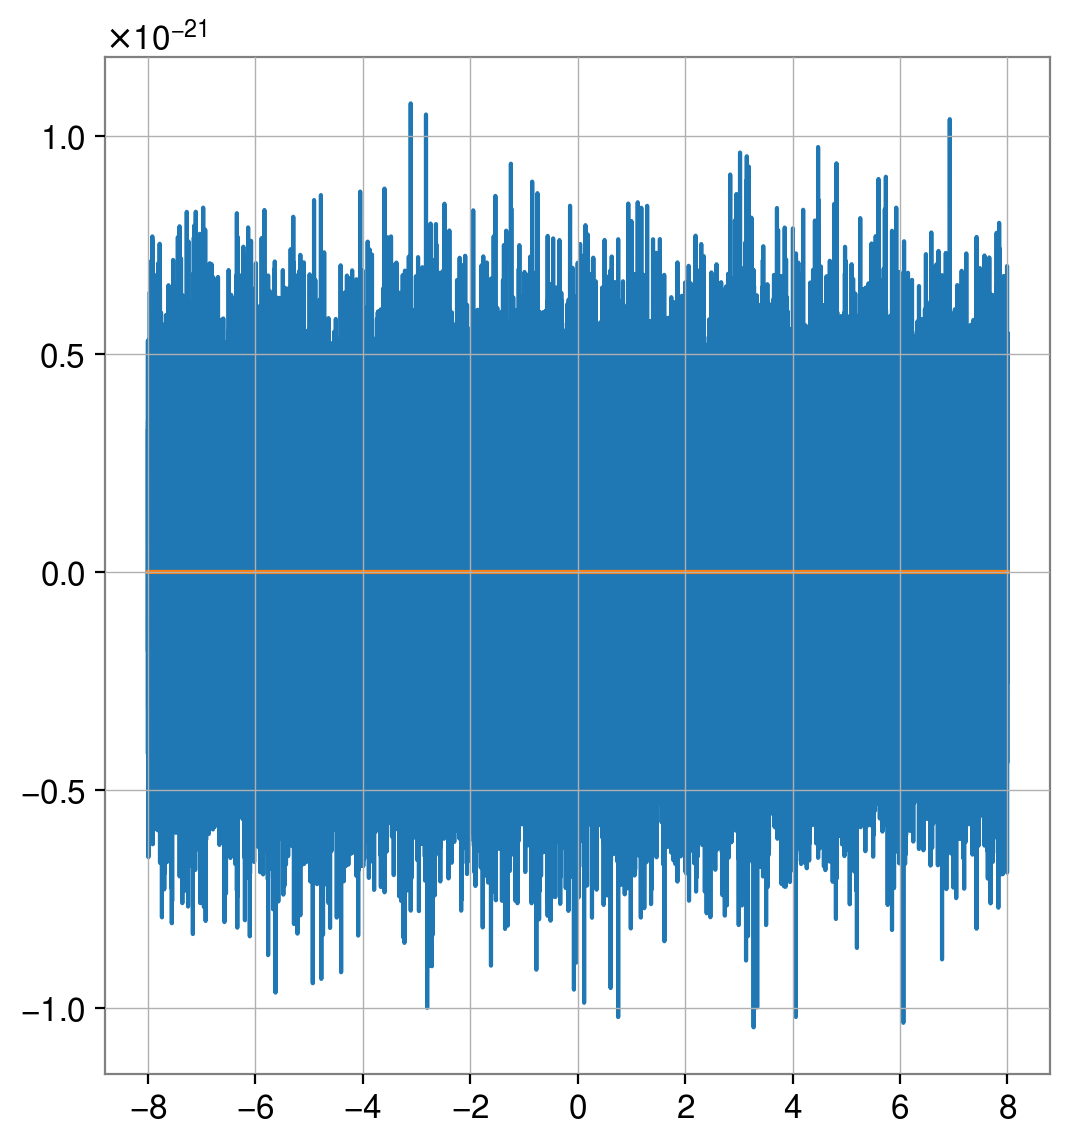

In [189]:
signalH_noise = 1.0*qnm_filter.bilby_get_strain(bilby_ifo)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_no_noise)
signalH_noise.plot()
signalH_no_noise.plot()

In [190]:
H_waveform = qnm_filter.Data(H_data.value+signalH_noise.values, index = H_data.times.value)
mass_unit = qnm_filter.Filter.mass_unit(theoretical_values[0])

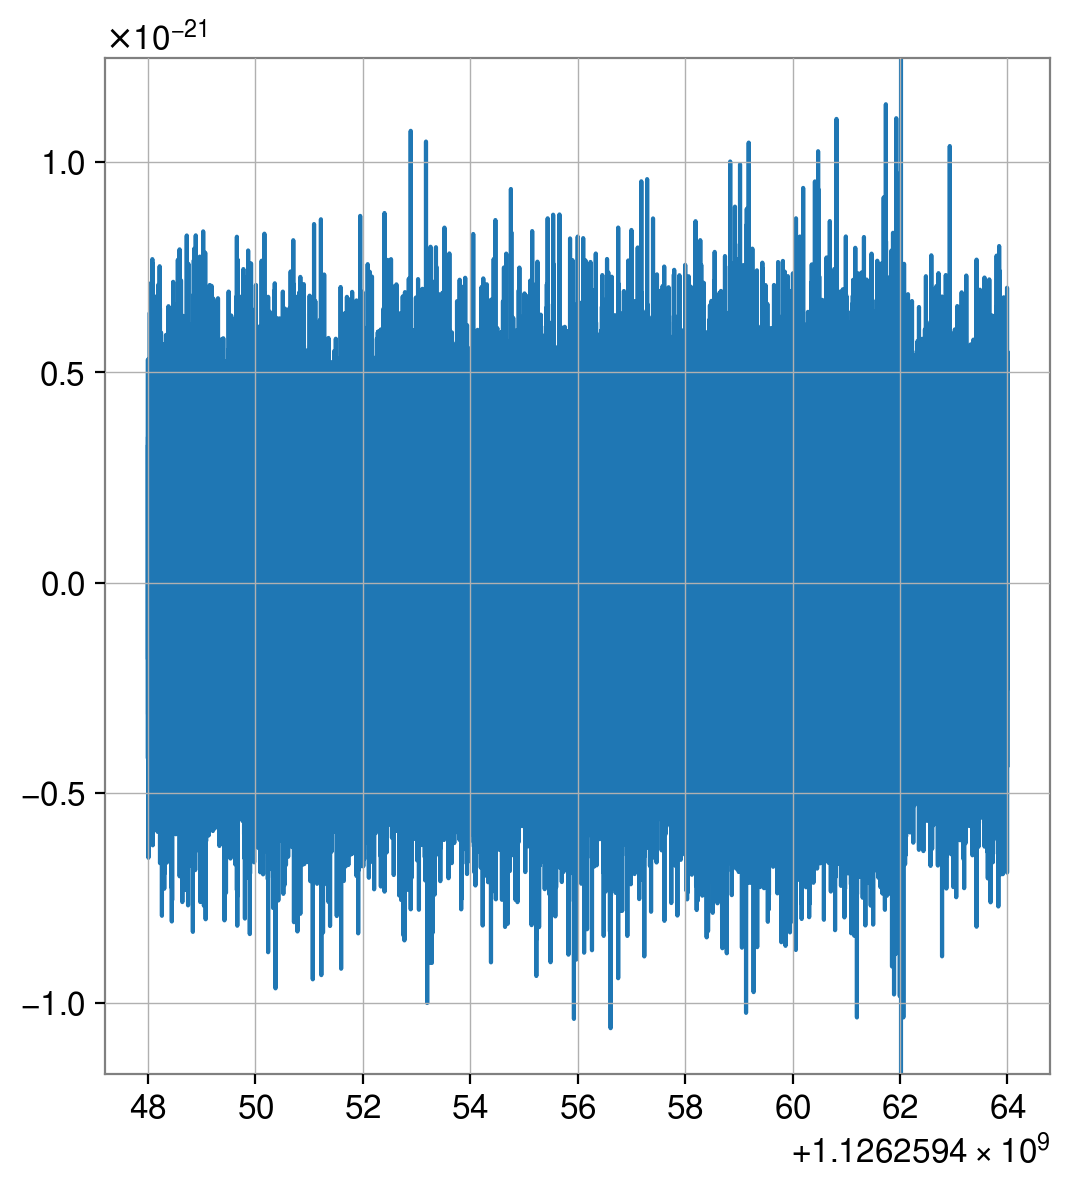

In [191]:
H_waveform.plot()
pl.axvline(peak_time)

### Ringdown analysis with rational filter(s)

In [247]:
input = dict(model_list = [(2,2,0),(2,2,1)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+0*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

In [248]:
fit.original_data['H1'] = H_waveform

In [249]:
fit.detector_alignment()

In [250]:
fit.condition_data('original_data', **input, trim = 0.0)
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.Data(signalH_noise.values, index = H_data.times.value)
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')

In [251]:
fit.cholesky_decomposition()

In [252]:
fit.first_index()

## SNR

In [253]:
fit_SNR = qnm_filter.Network(**input)
fit_SNR.original_data['H1'] = qnm_filter.Data(H_data.value, index = H_data.times.value)
fit_SNR.detector_alignment()
fit_SNR.condition_data('original_data', **input, trim = 0.0)
fit_SNR.compute_acfs('original_data')
fit_SNR.first_index()
fit.first_index()
template = fit_SNR.truncate_data(fit_SNR.original_data)['H1']

In [254]:
fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], template, 'H1', optimal=True)

13.628140069140036

Sampling remnant mass and spin

In [255]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [256]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

Plot 2d contours

In [257]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

Text(100, 0.1, 'ln(evidence) = -397.85')

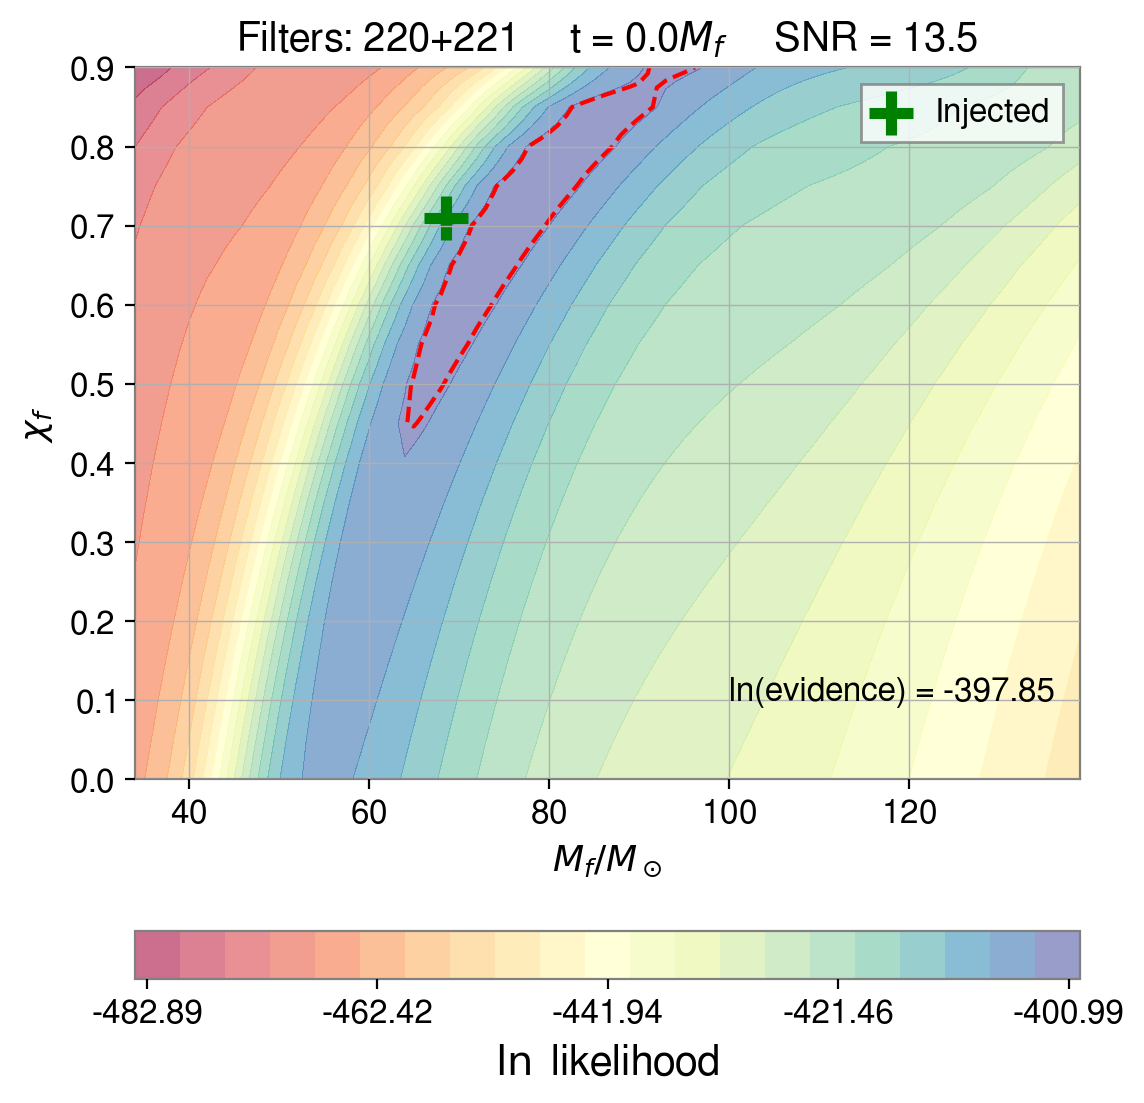

In [258]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$     SNR = 13.5')
ax.text(100, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

## Lots of filters on pure noise

In [112]:
H_waveform = qnm_filter.Data(0*H_data.value+signalH_noise.values, index = H_data.times.value)

evidence_arr = []
for i in range(10):
    input['model_list'] = [tuple((7,7,0)) for i in range(i)]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(signalH_noise.values, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

[]
[(7, 7, 0)]
[(7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


Text(0, 0.5, 'ln(evidence)')

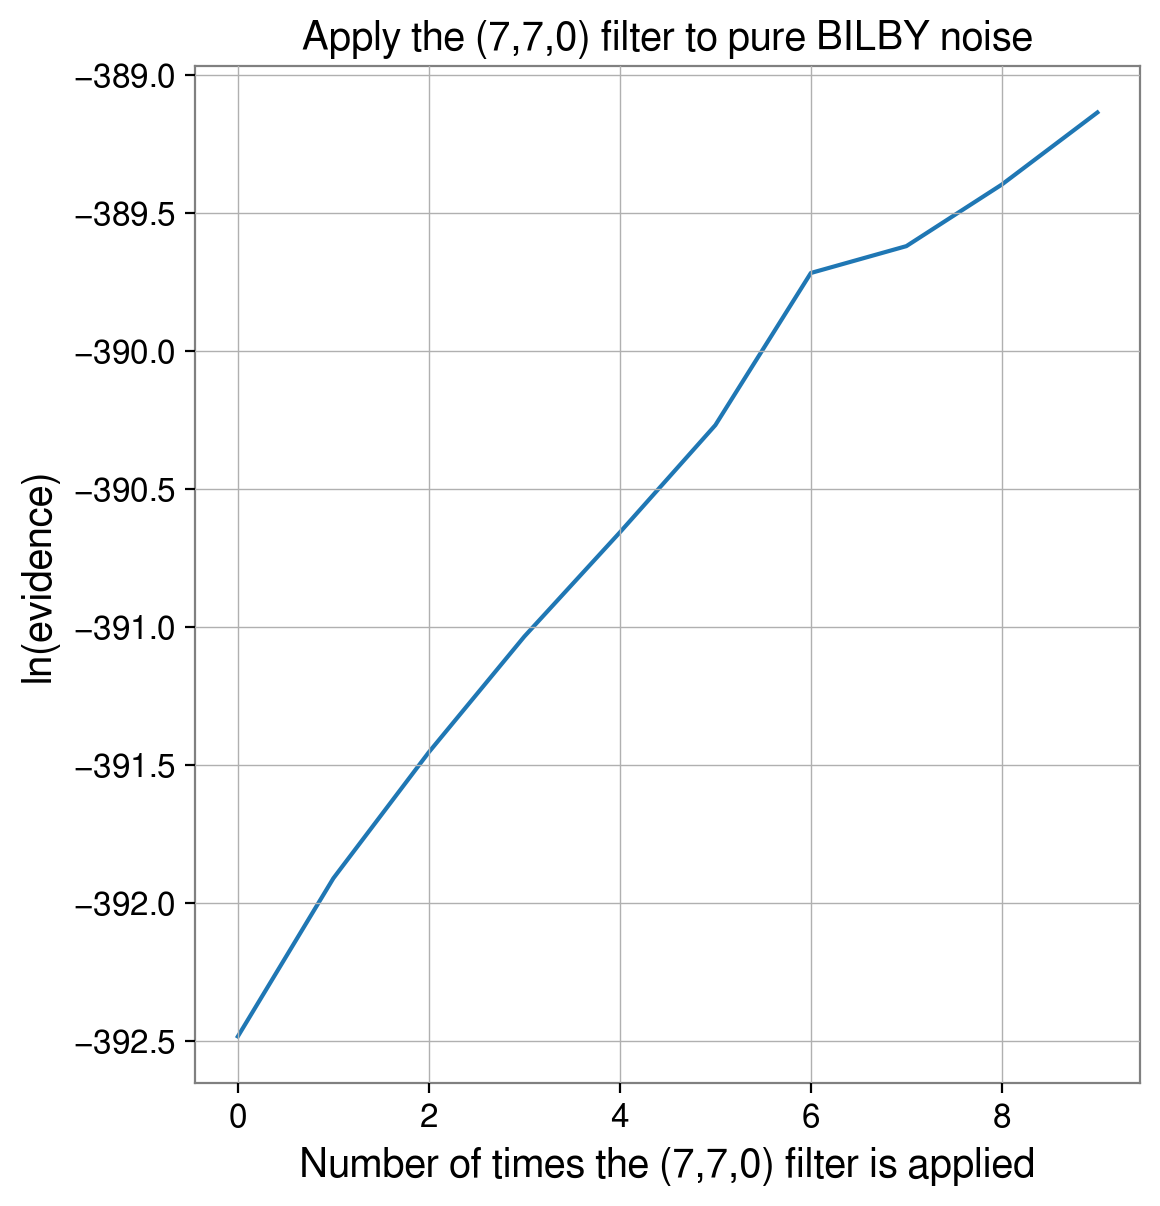

In [113]:
pl.plot(evidence_arr)
pl.title('Apply the (7,7,0) filter to pure BILBY noise')
pl.xlabel('Number of times the (7,7,0) filter is applied')
pl.ylabel("ln(evidence)")

## On the waveform with signal inside

In [80]:
H_waveform = qnm_filter.Data(1*H_data.value+signalH_noise.values, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
evidence_arr = []

for i in range(10):
    input['model_list'] = result_list[:i]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(signalH_noise.values, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

[]
[(7, 7, 0)]
[(7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


Text(0, 0.5, 'ln(evidence)')

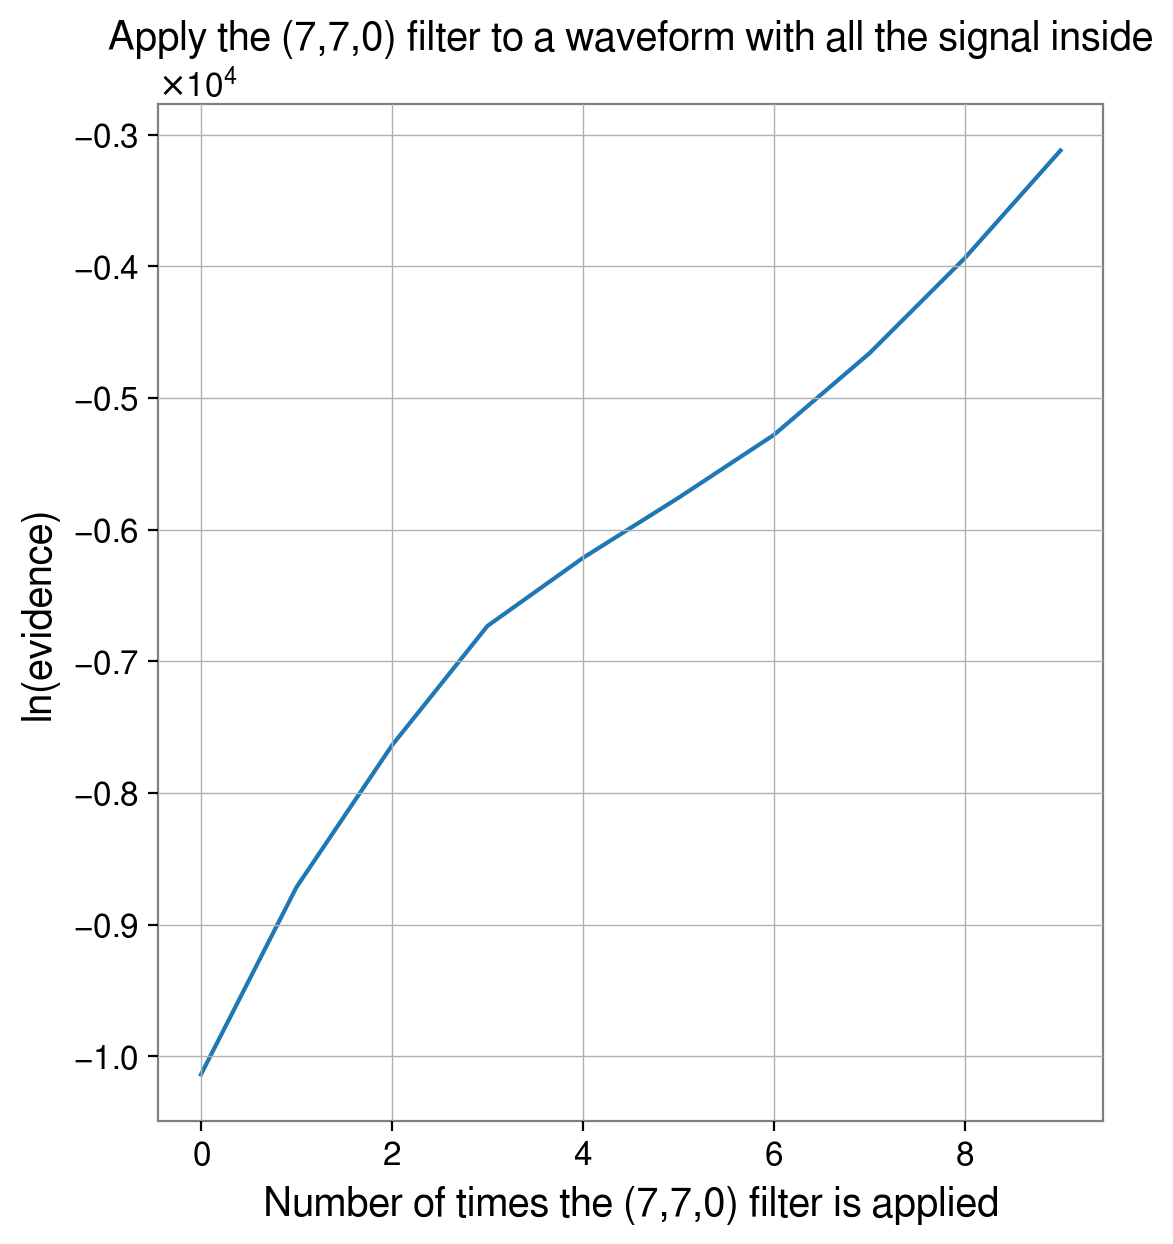

In [86]:
pl.plot(evidence_arr)
pl.title('Apply the (7,7,0) filter to a waveform with all the signal inside')
pl.xlabel('Number of times the (7,7,0) filter is applied')
pl.ylabel("ln(evidence)")

## On the waveform with (2,2,0) filter once

In [127]:
H_waveform = qnm_filter.Data(1*H_data.value+signalH_noise.values, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
result_list.insert(0, (2, 1, 0))
result_list.insert(0, (2, 2, 1))
result_list.insert(0, (2, 2, 0))
evidence_arr = []

for i in range(10):
    input['model_list'] = result_list[:i]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(signalH_noise.values, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

[]
[(2, 2, 0)]
[(2, 2, 0), (2, 2, 1)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 1, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


In [129]:
H_waveform = qnm_filter.Data(1*H_data.value+signalH_noise.values, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
result_list.insert(0, (2, 2, 2))
result_list.insert(0, (2, 2, 1))
result_list.insert(0, (2, 2, 0))
evidence_arr1 = []

for i in range(10):
    input['model_list'] = result_list[:i]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(signalH_noise.values, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr1.append(evidence)

[]
[(2, 2, 0)]
[(2, 2, 0), (2, 2, 1)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(2, 2, 0), (2, 2, 1), (2, 2, 2), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


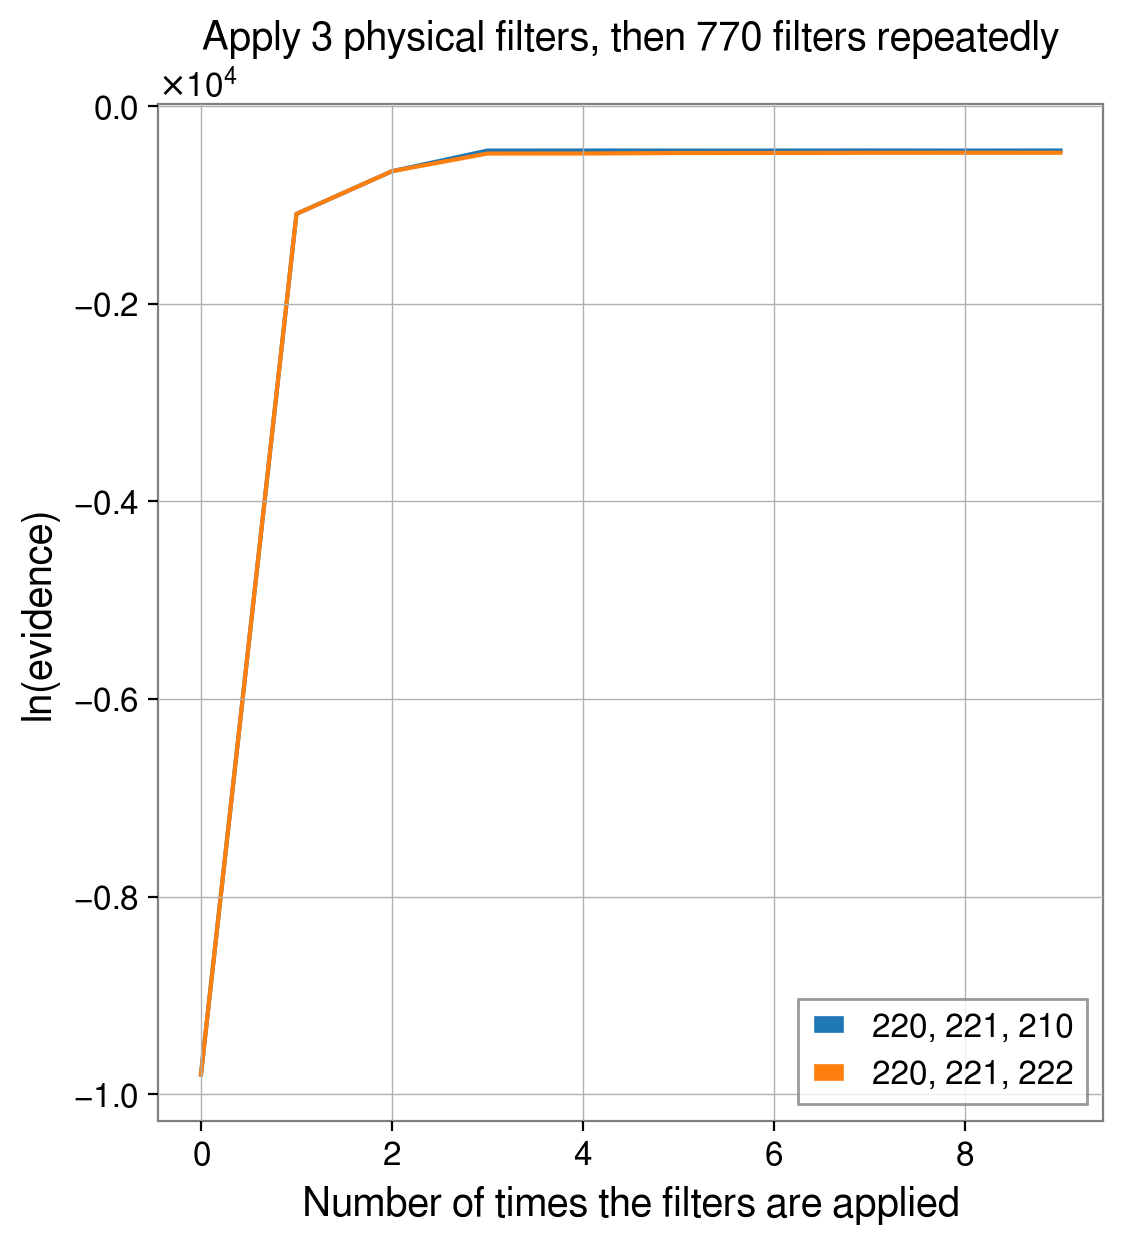

In [140]:
pl.plot(evidence_arr, label='220, 221, 210')
pl.plot(evidence_arr1, label='220, 221, 222')
# pl.ylim(-600, -400)
pl.title('Apply 3 physical filters, then 770 filters repeatedly')
pl.xlabel('Number of times the filters are applied')
pl.ylabel("ln(evidence)")
pl.legend()

In [134]:
evidence_arr[-1]

-449.8920383242002